# Predict DO with PyESPER

In [21]:
# imports
import numpy as np
import pandas
from importlib.resources import files
from importlib import reload

from matplotlib import pyplot as plt
import seaborn as sns

from PyESPER import lir as Py_lir

from cugn import io as cugn_io
from cugn import plotting

# Load up CUGN

In [3]:
line = '90.0'
items = cugn_io.load_up(line)
grid_extrem = items[0]
ds = items[1]
times = items[2]
grid_tbl = items[3]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


## Examine

In [4]:
ds

<xarray.Dataset> Size: 290MB
Dimensions:               (profile: 54842, trajectory: 70, depth: 50)
Coordinates:
  * profile               (profile) int32 219kB 0 1 2 3 ... 54839 54840 54841
    lat                   (profile) float64 439kB 33.44 33.44 ... 32.89 32.88
    lon                   (profile) float64 439kB -117.7 -117.7 ... -117.3
    lat_uv                (profile) float64 439kB 33.44 33.44 ... 32.89 32.88
    lon_uv                (profile) float64 439kB -117.7 -117.7 ... -117.3
    time                  (profile) datetime64[ns] 439kB 2006-10-19T17:51:00 ...
    time_uv               (profile) datetime64[ns] 439kB 2006-10-19T17:41:00 ...
  * depth                 (depth) int32 200B 10 20 30 40 50 ... 470 480 490 500
Dimensions without coordinates: trajectory
Data variables: (12/20)
    u_depth_mean          (profile) float64 439kB 0.03852 -0.01392 ... 0.04539
    v_depth_mean          (profile) float64 439kB -0.06798 0.02441 ... 0.02128
    mission               (profile) int32 219kB 0 0 0 0 0 0 ... 69 69 69 69 69
    mission_profile       (profile) int32 219kB 1 2 3 4 5 ... 976 977 978 979
    trajectory_index      (profile) int32 219kB 0 0 0 0 0 0 ... 69 69 69 69 69
    MLD                   (profile) float64 439kB 7.71 8.159 ... 7.533 8.07
    ...                    ...
    CT                    (depth, profile) float64 22MB 17.76 17.97 ... nan nan
    sigma0                (depth, profile) float64 22MB 24.07 24.03 ... nan nan
    SA                    (depth, profile) float64 22MB 33.49 33.5 ... nan nan
    SO                    (depth, profile) float64 22MB nan nan nan ... nan nan
    AOU                   (depth, profile) float64 22MB nan nan nan ... nan nan
    N                     (depth, profile) float64 22MB 12.03 11.15 ... nan nan
Attributes: (12/50)
    id:                              CUGN_line_90
    date_created:                    2023-08-22T08:43:54Z
    time_coverage_start:             2006-10-19T17:41:00Z
    time_coverage_end:               2023-03-20T15:42:26Z
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds:               POLYGON ((-121.0906975 21.58784, -121.09...
    ...                              ...
    platform_institution:            Scripps Institution of Oceanography
    sea_name:                        Coastal Waters of California
    summary:                         The overarching goal of the California U...
    references:                      Rudnick, D. L. (2016). Ocean research en...
    title:                           California Underwater Glider Network - L...
    site:                            CUGN Line 90

## Grab the variables we need, and parse out junk

In [5]:
iz = 5  # depth = 50m

In [16]:
T = ds.temperature[iz,:]
S = ds.salinity[iz,:]
DO = ds.doxy[iz,:]
S.shape

(54842,)

In [7]:
keep = np.isfinite(T.values) & np.isfinite(S.values)
np.sum(keep)

np.int64(51107)

## Format for PyESPER

In [8]:
OutputCoordinates = {}
PredictorMeasurements = {}

OutputCoordinates.update({"longitude": ds.lon.values[keep].tolist(), 
                          "latitude": ds.lat.values[keep].tolist(), 
                          "depth": [5. + iz*10]*np.sum(keep)})

PredictorMeasurements.update({"salinity": S[keep].values.tolist(),
                              "temperature": T[keep].values.tolist(),
                             })

In [9]:
for key in OutputCoordinates.keys():
    print(OutputCoordinates[key][0:5])
print('------')
for key in PredictorMeasurements.keys():
    print(PredictorMeasurements[key][0:5])

[-117.72813000000001, -117.73344, -117.74338499999999, -117.7526625, -117.7620275]
[33.43725, 33.43589, 33.43557, 33.43938, 33.448135]
[55.0, 55.0, 55.0, 55.0, 55.0]
------
[33.352, 33.354625, 33.346375, 33.34611111111112, 33.34916666666667]
[12.538857142857143, 12.481875000000002, 12.525000000000002, 12.462888888888891, 12.607833333333337]


## Dates

In [10]:
dates = pandas.to_datetime(ds.time[keep])

# Convert to decimal years
decimal_years = dates.year + (dates.dayofyear - 1) / 365.25

print(decimal_years)

Index([2006.7967145790553, 2006.7967145790553, 2006.7967145790553,
       2006.7967145790553, 2006.7967145790553, 2006.7994524298426,
       2006.7994524298426, 2006.7994524298426, 2006.7994524298426,
       2006.7994524298426,
       ...
       2023.2135523613963, 2023.2135523613963, 2023.2135523613963,
       2023.2135523613963, 2023.2135523613963, 2023.2135523613963,
       2023.2135523613963, 2023.2135523613963, 2023.2135523613963,
       2023.2135523613963],
      dtype='float64', length=51107)


In [11]:
EstDates = decimal_years.tolist()

# Let's rock

In [12]:
pyESPER_path = files('PyESPER').joinpath('../')

In [13]:
reload(Py_lir)
EstimatesLIR, UncertaintiesLIR, CoefficientsLIR = Py_lir.PyESPER_LIR(
    ['oxygen'], pyESPER_path, OutputCoordinates, PredictorMeasurements, EstDates=EstDates, Equations=[8])

PyESPER_LIR took 24.9300 seconds, or 0.4155 minutes to run


In [14]:
EstimatesLIR

,oxygen8
0,208.735763
1,207.984329
2,209.278754
3,208.799550
4,209.849230
...,...
51102,144.042912
51103,145.019770
51104,138.615614
51105,136.686846


# Comparison time

In [17]:
CUGN_DO = DO[keep].values

In [25]:
dDO = CUGN_DO -  EstimatesLIR.oxygen8.values

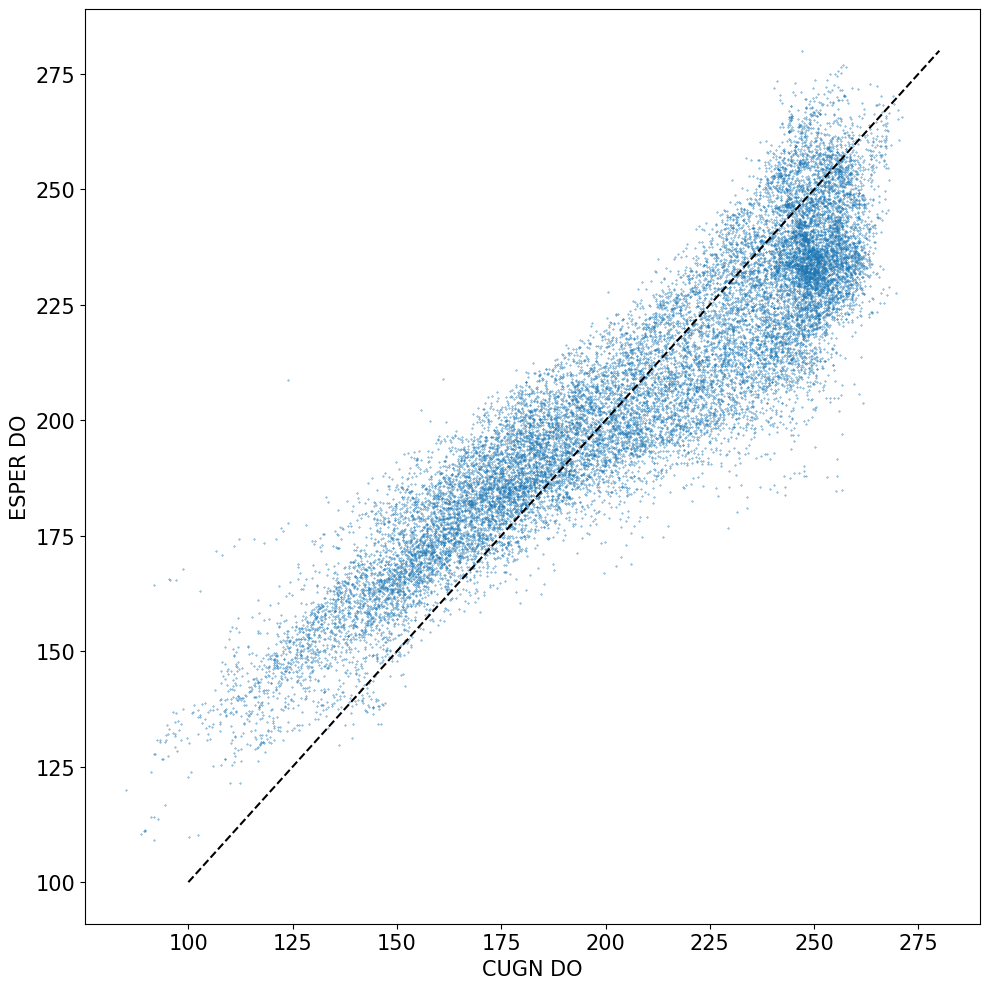

In [24]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.scatter(CUGN_DO, EstimatesLIR.oxygen8.values, s=0.1)
# 1-1 line
ax.plot([100., 280.], [100., 280], ls='--', c='k')
# Label
ax.set_xlabel('CUGN DO')
ax.set_ylabel('ESPER DO')
#
plotting.set_fontsize(ax, 15.)
#
plt.tight_layout()
plt.savefig('fig_ESPER_vs_CUGN.png', dpi=300)
plt.show()

## Vs. T

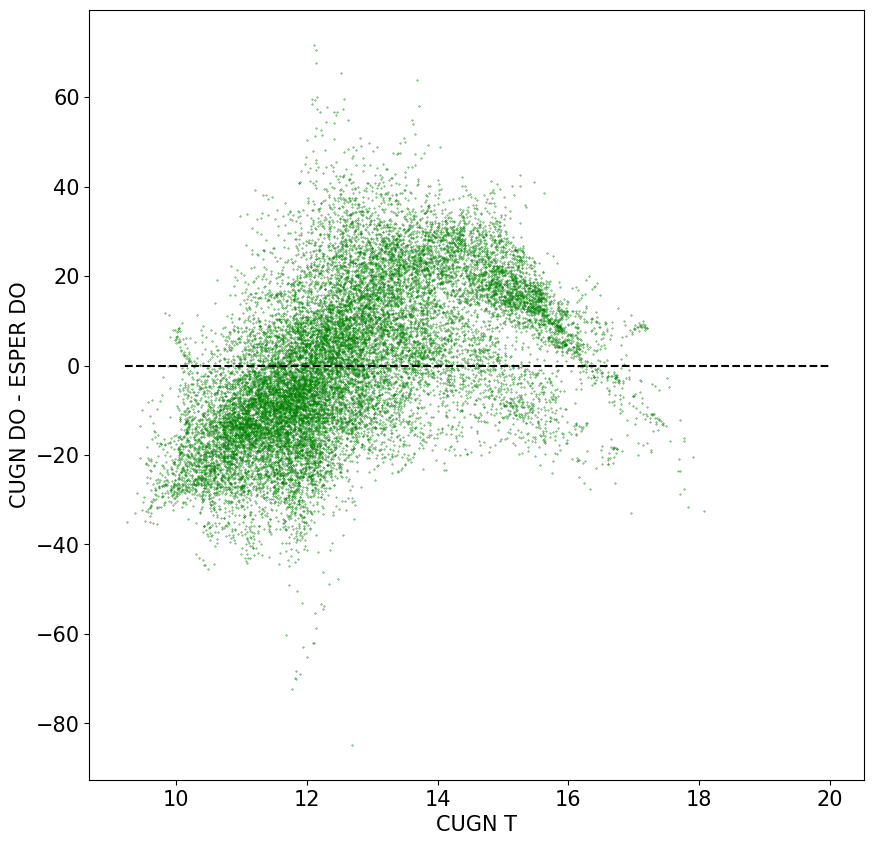

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.scatter(T[keep].values, dDO, s=0.1, c='g')
# 1-1 line
ax.plot([T[keep].values.min(), T[keep].values.max()], [0.]*2, c='k', ls='--')
# Label
ax.set_xlabel('CUGN T')
ax.set_ylabel('CUGN DO - ESPER DO')
#
plotting.set_fontsize(ax, 15.)
#
#plt.tight_layout()
#plt.savefig('fig_ESPER_vs_CUGN.png', dpi=300)
plt.show()

## Exploring the Errors

In [29]:
UncertaintiesLIR

,oxygen8
0,19.258765
1,19.247154
2,19.283646
3,19.284814
4,19.271298
...,...
51102,17.250645
51103,17.283541
51104,17.065536
51105,16.994169


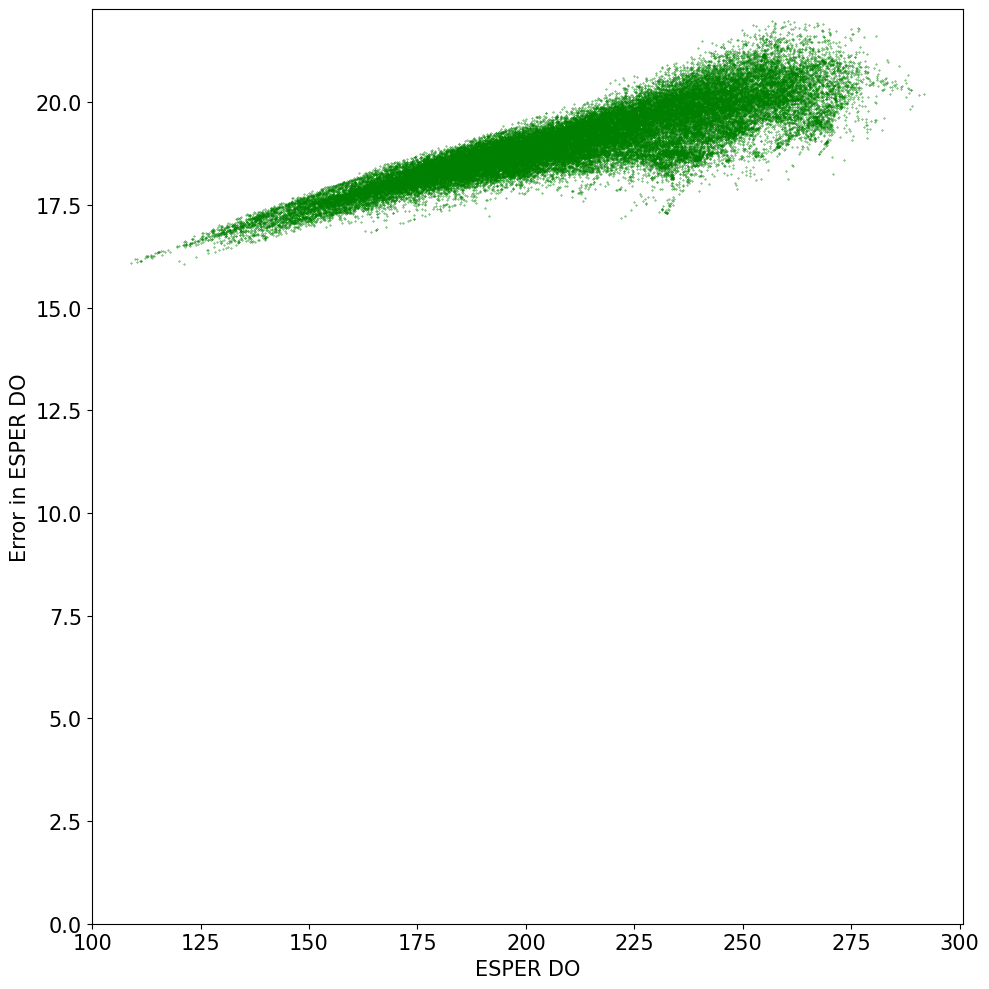

In [34]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.scatter(EstimatesLIR.oxygen8, UncertaintiesLIR.oxygen8, s=0.1, c='g')
# 1-1 line
#ax.plot([T[keep].values.min(), T[keep].values.max()], [0.]*2, c='k', ls='--')
# Label
ax.set_xlabel('ESPER DO')
ax.set_ylabel('Error in ESPER DO')
#
ax.set_ylim(0., None)
#
plotting.set_fontsize(ax, 15.)
#
plt.tight_layout()
plt.savefig('fig_ESPER_error.png', dpi=300)
plt.show()